https://www.kaggle.com/c/quora-question-pairs

# Goal

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

Please note: as an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.

# Data fields

- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack

# Read files
Read files and gather all questions

In [2]:
train_df = pd.read_csv("train.csv.zip").replace(np.nan, '', regex=True)
test_df = pd.read_csv("test.csv.zip").replace(np.nan, '', regex=True)

In [3]:
train_q = pd.Series(train_df["question1"].tolist() + train_df["question2"].tolist()).drop_duplicates()
test_q = pd.Series(test_df["question1"].tolist() + test_df["question2"].tolist()).drop_duplicates()

In [4]:
complete_data = train_q.append(test_q)

# Useful functions

In [5]:
def get_row_transformation(transformed_data, word_features, row_index):
    """
    given data that was transformed with countVectorizer, check the value of each index and which word it corresponds
    """
    ex_row = transformed_data.getrow(row_index)
    print(ex_row.data)
    print(ex_row.indices)
    print([word_features[i] for i in ex_row.indices])

In [6]:
def build_features(pipeline, data):
    """
    Both columns of questions the pipeline is applied and then the vectors are stacked horizontally (rows get bigger)
    """
    question1_transformed = pipeline.transform(data["question1"])
    question2_transformed = pipeline.transform(data["question2"])
    
    return(hstack([question1_transformed, question2_transformed]))

In [7]:
def write_submission_file(test_probabilities):
    """
    Given probability output, write the submission file
    """
    prob_series = pd.Series(test_probabilities.transpose()[1])   
    pd.DataFrame({"test_id": test_df.test_id, "is_duplicate": prob_series}).to_csv("submission.csv", index = False)

In [8]:
thousand_regex = re.compile(r'(?<=[0-9])k')
joined_regex = re.compile(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)')
regex_not = re.compile('n\'t')
regex_is = re.compile(r'\'s')
regex_are = re.compile(r'\'re')
regex_am = re.compile(r'\'m')
regex_have = re.compile(r'\'ve')
regex_will = re.compile(r'\'ll')
regex_will_not = re.compile(r'won\'t')
regex_special_characters = re.compile(r'[\'\"\\\/!?\(\)\-:,]')

def correct_strings(string):
    """
    Expand some common abbreviations
    """
    string = re.sub(thousand_regex,"000", string) #replace k with thousands
    string = re.sub(joined_regex," ", string) #space numbers and characters
    string = re.sub(regex_will_not,"will not", string)
    string = re.sub(regex_not," not", string)
    string = re.sub(regex_is," is", string)
    string = re.sub(regex_are," are", string)
    string = re.sub(regex_am," am", string)
    string = re.sub(regex_have," have", string)
    string = re.sub(regex_will," will", string)
    string = re.sub(regex_special_characters," ", string)
    string = re.sub('\s+', ' ', string) #trailing white spaces
    string.strip()
    return(string)

def apply_correct_string(series):
    return(series.apply(correct_strings))

In [9]:
def count_occurences(regex):
    """
    Check how many questions satisfy a particular regex
    """
    print(train_df.question1.apply(lambda x: exists_regex(regex, x)).value_counts(normalize = True))
    print(train_df.question2.apply(lambda x: exists_regex(regex, x)).value_counts(normalize = True))
    print(test_df.question1.apply(lambda x: exists_regex(regex, x)).value_counts(normalize = True))
    print(test_df.question2.apply(lambda x: exists_regex(regex, x)).value_counts(normalize = True)) 

# Initial analysis

In [3]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [34]:
len(train_df)

404290

In [4]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [35]:
len(test_df)

2345796

Check unique questions in each set

In [33]:
print(len(train_q))
print(len(test_q))

537362
4363832


## Target variable

In [36]:
pd.DataFrame({"absolute": train_df.is_duplicate.value_counts(),"normalized":train_df.is_duplicate.value_counts(normalize = True)})

,absolute,normalized
0,255027,0.630802
1,149263,0.369198


## Check null questions

### Train

In [3]:
q1_null = train_df["question1"][[s is '' for s in train_df["question1"]]]
train_df.loc[q1_null.index.tolist()]

,id,qid1,qid2,question1,question2,is_duplicate


In [4]:
q2_null = train_df["question2"][[s is '' for s in train_df["question2"]]]
train_df.loc[q2_null.index.tolist()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,,0
201841,201841,303951,174364,How can I create an Android app?,,0


### Test

In [5]:
q1t_null = test_df["question1"][[s is '' for s in test_df["question1"]]]
test_df.loc[q1t_null.index.tolist()]

,test_id,question1,question2
1046690,1046690,,How I what can learn android app development?
1461432,1461432,,How distinct can learn android app development?


In [6]:
q2t_null = test_df["question2"][[s is '' for s in test_df["question2"]]]
test_df.loc[q2t_null.index.tolist()]

,test_id,question1,question2
379205,379205,How I can learn android app development?,
817520,817520,How real can learn android app development?,
943911,943911,How app development?,
1270024,1270024,How I can learn app development?,


# Extracting features from text files
Want to convert words into vectors. For that we shall use CountVectorizer. And as a preprocessor we remove all punctuation.

TODO: do n-grams, stemming (using NLTK library)

In [39]:
count_vect = CountVectorizer()

In [40]:
train_counts = count_vect.fit_transform(train_q)

In [16]:
word_features = count_vect.get_feature_names()
train_counts.shape

(537362, 86153)

In [38]:
get_row_transformation(train_q, word_features, 4)
print(train_q[4])

NameError: name 'word_features' is not defined

Since synonyms will be very useful here, it may be a good idea to use word2vec.

# Model

In [20]:
rfc = RandomForestClassifier()

On a first since we are going for sentences with similar meaning we subtract the questions, the closer to 0 the more similar those sentences should be.

In [10]:
question1_transformed = count_vect.transform(train_df["question1"])
question2_transformed = count_vect.transform(train_df["question2"])
X_train = question1_transformed - question2_transformed

In [24]:
train_result = rfc.fit(X_train, train_df.is_duplicate)

Check results on training data

In [ ]:
train_res = train_result.predict(X_train)
train_prob = train_result.predict_proba(X_train)
probabilities_df = pd.DataFrame({"real": train_df.is_duplicate, "prob": pd.Series(train_prob.transpose()[1])})
plt.hist(probabilities_df[probabilities_df.real == 1].prob)
plt.hist(probabilities_df[probabilities_df.real == 0].prob)

## Test data

In [13]:
question1_test_transformed = count_vect.transform(test_df["question1"])
question2_test_transformed = count_vect.transform(test_df["question2"])
X_test = question1_test_transformed - question2_test_transformed

In [ ]:
test_prob = rfc.predict_proba(X_test)
pd.DataFrame({"test_id": test_df.test_id, "is_duplicate": pd.Series(test_prob.transpose()[1])}).to_csv("submission.csv", index = False)

Score: 0.92

# Model 2: Concatenating the two sentence vectors
Now we just concatenate the two questions instead of doing a subtraction

In [43]:
pipeline_2 = make_pipeline(CountVectorizer())
pipeline_2 = pipeline_2.fit(complete_data)

In [50]:
rfc2 = RandomForestClassifier(n_estimators=200)

In [51]:
x_train_2 = build_features(pipeline_2, train_df)
train_result_2 = rfc2.fit(x_train_2, train_df.is_duplicate)

In [52]:
x_test_2 = build_features(pipeline_2, test_df)
test_prob_2 = rfc2.predict_proba(x_test_2)
write_submission_file(test_prob_2)

Score: 0.415

## Further analysis

In [54]:
test_prob_2

array([[ 0.68,  0.32],
       [ 0.76,  0.24],
       [ 0.68,  0.32],
       ..., 
       [ 0.88,  0.12],
       [ 0.96,  0.04],
       [ 0.44,  0.56]])

# Model 3: Using tf-idf

In [21]:
pipeline_3 = make_pipeline(CountVectorizer(),TfidfTransformer())
pipeline_3 = pipeline_3.fit(complete_data)

In [23]:
#train
rfc3 = RandomForestClassifier(n_estimators=200)

In [24]:
x_train_3 = build_features(pipeline_3, train_df)
train_result_3 = rfc3.fit(x_train_3, train_df.is_duplicate)

In [25]:
#test
x_test_3 = build_features(pipeline_3, test_df)
test_prob_3 = rfc3.predict_proba(x_test_3)
write_submission_file(test_prob_3)

Score was 0.375

### Further analysis

(array([  1.24583000e+05,   7.76710000e+04,   3.44750000e+04,
          1.29040000e+04,   4.08500000e+03,   1.40000000e+01,
          1.03200000e+03,   2.13000000e+02,   4.30000000e+01,
          7.00000000e+00]),
 array([ 0.        ,  0.08166667,  0.16333333,  0.245     ,  0.32666667,
         0.40833333,  0.49      ,  0.57166667,  0.65333333,  0.735     ,
         0.81666667]),
 <a list of 10 Patch objects>)

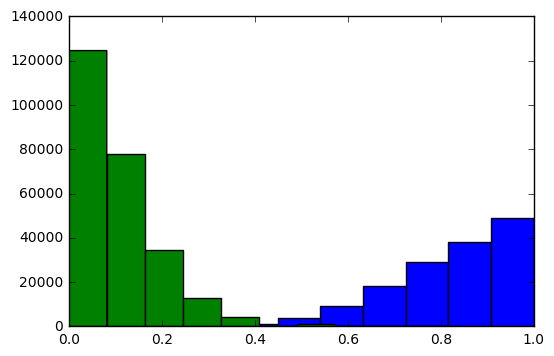

In [27]:
#Plots
train_prob = train_3_result.predict_proba(X_train_3)
probabilities_df = pd.DataFrame({"real": train_df.is_duplicate, "prob": pd.Series(train_prob.transpose()[1])})

plt.hist(probabilities_df[probabilities_df.real == 1].prob)
plt.hist(probabilities_df[probabilities_df.real == 0].prob)

# Model 4: Processing text
Some text like abbreviations can and should be processed.
But we shall not focus on removing stop words nor handling unknown words.

In [14]:
pipeline_4 = make_pipeline(FunctionTransformer(apply_correct_string, validate = False),
                                CountVectorizer(),
                                TfidfTransformer())
pipeline_4 = pipeline_4.fit(complete_data)

Check one row:

In [15]:
rfc4 = RandomForestClassifier(n_estimators=100)

In [16]:
#train
x_train_4 = build_features(pipeline_4, train_df)
train_result_4 = rfc4.fit(x_train_4, train_df.is_duplicate)

In [17]:
#test
x_test_4 = build_features(pipeline_4, test_df)
test_prob_4 = rfc4.predict_proba(x_test_4)
write_submission_file(test_prob_4)

Scored:0.368

# Further analysis

In [ ]:
q1t = pipeline_4.transform(train_df["question1"])
get_row_transformation(q1t, model_pipeline_4.steps[1][1].get_feature_names(), 15)

# Model 5: Common words
Now we are going to compute the percentage of common words in both questions. The higher the number of common words it should be more likely that they mean the same (synonyms ruin this hypothesis).
And this way if new words appear in the test set they will already be accounted in this percentage.

In [11]:
def split_sentences(series):
    return(series.apply(lambda x: x.strip().lower().split(" ")))

In [15]:
q1t = split_sentences(apply_correct_string(train_df["question1"]))
q2t = split_sentences(apply_correct_string(train_df["question2"]))

In [8]:
print(q1t[1])
print(q2t[1])

['what', 'is', 'the', 'story', 'of', 'kohinoor', 'koh', 'i', 'noor', 'diamond']
['what', 'would', 'happen', 'if', 'the', 'indian', 'government', 'stole', 'the', 'kohinoor', 'koh', 'i', 'noor', 'diamond', 'back']


In [12]:
def count_common_words(sentence1, sentence2):
    count1 = 0
    count2 = 0
    
    q1words = {word: 1 for word in sentence1}   
    gen = (word2 for word2 in sentence2 if word2 in q1words)
    for x in gen:
        count2 += 1
        
    q2words = {word: 1 for word in sentence2}   
    gen = (word1 for word1 in sentence1 if word1 in q2words)
    for x in gen:
        count1 += 1  
        
    return pd.Series([count1/len(sentence1),count2/len(sentence2)])

In [10]:
print(q1t[0])
print(q2t[0])

['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']
['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market']


In [11]:
count_common_words(q1t[0], q2t[0])

0    0.928571
1    1.000000
dtype: float64

In [16]:
common = pd.DataFrame({"1": q1t,"2":q2t}).apply(lambda row: count_common_words(row['1'],row['2']), axis = 1)

In [17]:
rfc5 = RandomForestClassifier()
train_5_result = rfc5.fit(common, train_df.is_duplicate)

(array([  8.02670000e+04,   2.55160000e+04,   2.38570000e+04,
          2.38720000e+04,   3.84660000e+04,   4.78250000e+04,
          1.23930000e+04,   2.18100000e+03,   6.00000000e+02,
          5.00000000e+01]),
 array([ 0.        ,  0.09924603,  0.19849206,  0.2977381 ,  0.39698413,
         0.49623016,  0.59547619,  0.69472222,  0.79396825,  0.89321429,
         0.99246032]),
 <a list of 10 Patch objects>)

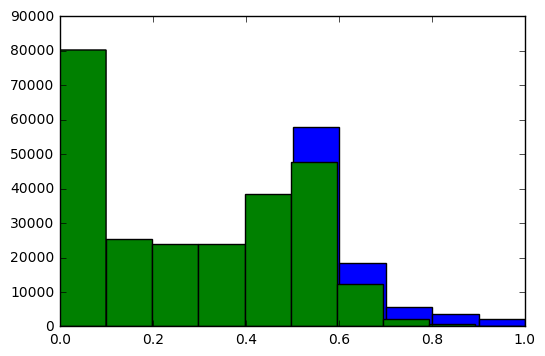

In [19]:
#Plots
train_prob = train_5_result.predict_proba(common)
probabilities_df = pd.DataFrame({"real": train_df.is_duplicate, "prob": pd.Series(train_prob.transpose()[1])})

plt.hist(probabilities_df[probabilities_df.real == 1].prob)
plt.hist(probabilities_df[probabilities_df.real == 0].prob)

## Ensemble

In [21]:
train_prob_4 = rfc4.predict_proba(X_train_4)

In [23]:
ensemble_concat = pd.concat([common,pd.Series(train_prob_4.transpose()[1])], axis = 1)

In [25]:
rfc52 = RandomForestClassifier(n_estimators=50, min_samples_split = 5, min_samples_leaf = 2)
train_52_result = rfc52.fit(ensemble_concat, train_df.is_duplicate)

(array([  2.50209000e+05,   1.87000000e+03,   1.22900000e+03,
          3.26000000e+02,   1.88000000e+02,   1.30000000e+02,
          3.66000000e+02,   3.79000000e+02,   1.62000000e+02,
          1.68000000e+02]),
 array([ 0.        ,  0.0995897 ,  0.1991794 ,  0.29876911,  0.39835881,
         0.49794851,  0.59753821,  0.69712791,  0.79671761,  0.89630732,
         0.99589702]),
 <a list of 10 Patch objects>)

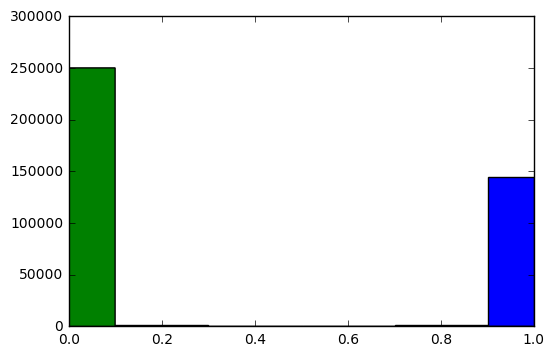

In [26]:
train_prob_52 = train_52_result.predict_proba(ensemble_concat)
probabilities_df = pd.DataFrame({"real": train_df.is_duplicate, "prob": pd.Series(train_prob_52.transpose()[1])})

plt.hist(probabilities_df[probabilities_df.real == 1].prob)
plt.hist(probabilities_df[probabilities_df.real == 0].prob)

In [27]:
q1x = split_sentences(apply_correct_string(test_df["question1"]))
q2x = split_sentences(apply_correct_string(test_df["question2"]))
common_test = pd.DataFrame({"1": q1x,"2":q2x}).apply(lambda row: count_common_words(row['1'],row['2']), axis = 1)
ensemble_concat_2 = pd.concat([common_test,pd.Series(test_prob_4.transpose()[1])], axis = 1)

In [28]:
ensemble_concat_2

,0,1,0
0,0.363636,0.187500,0.1
1,0.357143,0.714286,0.1
2,0.428571,0.833333,0.3
3,0.000000,0.000000,0.0
4,0.750000,0.500000,0.4
5,0.300000,0.200000,0.2
6,0.700000,0.636364,0.6
7,0.444444,0.470588,0.9
8,0.777778,0.727273,0.2
9,0.260870,0.545455,0.1


In [29]:
train_prob_53 = rfc52.predict_proba(ensemble_concat_2)

In [31]:
pd.DataFrame({"test_id": test_df.test_id, "is_duplicate": pd.Series(train_prob_53.transpose()[1])}).to_csv("submission.csv", index = False)